# Sequential Importance Resampling (SIR)

This notebook implements a sequential Monte Carlo method called sequential importance resampling (SIR). Similar to a particle filter, SIR infers the latent trajectory of a state-space model that generates a timeseries of observed data. In this example, we use SIR to infer the latent dynamics that generate a neural spike train. 

In our case, we assume the latent process evolves according to a random walk with drift until it reaches a threshold. At each time step in the sequence of observed data, the latent state determines the rate parameter of a Poisson process, which then generates the observed data. When we know the parameters that dictate the random walk and the function that maps the latent state to the Poisson rate parameter, we can estimate the value of the latent state at each step in the timeseries. In a carefully crafted neuroscience experiment, these latent states may tell us something about computation in the brain. 

SIR uses the basic ideas of importance sampling to sample the otherwise intractable posterior distribution of latent trajectories over the entire timeseries. At each time step t, we sample a state for the latent process at time t + 1 based on the value of the latent process at time t (the Markovian structure of the latent process allows us to do this easily). We do this for a large number of "particles." We then weight the likelihood of the proposed samples according to the likelihood of the observed data at time t + 1 given the proposed latent states at time t + 1. To improve accuracy, increase computational efficiency, and prevent degeneracy, we resample the complete paths of the particles according to these weights. Particles with larger weights are thus resampled more often, and contribute more to the estimate of the posterior. Particles with low weights are not resampled often (eventually getting thrown out), and contribute little to the estimate of the posterior. 

We simulate both a latent trajectory and observed data from a known state-space model below. SIR does reasonably well to recover the latent dynmaics. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.ndimage import gaussian_filter1d

In [4]:
## Define the model 

# Need to change to brownian motion where the conditional distribution given last time step is log normal with mean beta + ln(s_(t-1)) and variance = var

def rw_with_drift(beta, var, intercept, threshold):

    current_val = intercept
    time = 1
    trajectory = []

    while current_val < threshold:

        current_val += (beta + (np.sqrt(var) * np.random.normal()))
        trajectory = np.append(trajectory, current_val)
        time += 1

    return trajectory


## Simulate spikes

def state_to_lambda(state_trajectory, C, baseline):

    rate_params = np.log(1 + np.exp(C * state_trajectory + baseline)) # softplus to handle negatives 
    spike_counts = np.random.poisson(rate_params)

    return rate_params, spike_counts

def get_arrival_times(state_trajectory, rate_params, spike_counts, bin_size):

    arrival_times = []

    for ii_bin in range(len(state_trajectory)):

        if spike_counts[ii_bin] == 0:

            continue

        else:

            while True:
            
                temp_cumsum = np.cumsum(np.random.exponential(1 / rate_params[ii_bin], spike_counts[ii_bin])) * bin_size

                if temp_cumsum[-1] < bin_size:

                    break
                
            arrival_times = np.append(arrival_times, (ii_bin * bin_size) + temp_cumsum)

    return arrival_times

## Sequential importance resampling 

def propose_next_state(params, current_val):

    beta = params['beta']
    var = params['var']
    proposal = (beta + current_val) + np.sqrt(var) * np.random.normal()

    return proposal

def seq_importance_resampling(params, num_particles, num_time_steps, spike_counts):

    particles = np.zeros([num_particles, num_time_steps])
    temp_weights = np.zeros([num_particles])
    weights_hist = {}
    particle_history = {}

    C = params['C']
    baseline = params['baseline']

    for ii_time_step in range(num_time_steps):

        print('Time step', ii_time_step) if ii_time_step % 50 == 0 else None
        current_num_spikes = spike_counts[ii_time_step]

        for jj_particle in range(num_particles):

            if ii_time_step == 0:

                particles[jj_particle, ii_time_step] = propose_next_state(params, params['intercept'])

            else:

                particles[jj_particle, ii_time_step] = propose_next_state(params, particles[jj_particle, ii_time_step - 1])

            temp_weights[jj_particle] = poisson.pmf(current_num_spikes, 
                                            np.log(1 + np.exp(C * particles[jj_particle, ii_time_step] + baseline)))

        # Normalize importance weights for resampling

        norm_weights = temp_weights / np.sum(temp_weights)
        weights_hist[str(ii_time_step)] = norm_weights

        # Resample the trajectories (total trajectory, not just last step)

        resampled_indices = np.random.choice(num_particles, num_particles, p = norm_weights)
        particles[:, 0 : ii_time_step + 1] = particles[resampled_indices, 0 : ii_time_step + 1]
        particle_history[str(ii_time_step + 1)] = particles[:, 0 : ii_time_step + 1]

    return particles, particle_history

We generate the latent process and observed data below. 

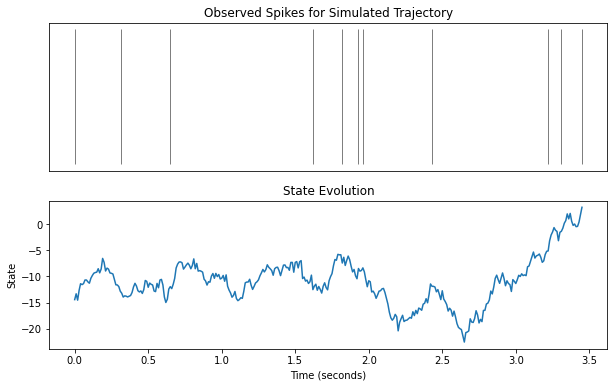

In [5]:
beta = .02
var = 1
intercept = -12
threshold = 3
state_trajectory = rw_with_drift(beta, var, intercept, threshold)

C = .175
baseline = -2
bin_size = .01
rate_params, spike_counts = state_to_lambda(state_trajectory, C, baseline)
arrival_times = get_arrival_times(state_trajectory, rate_params, spike_counts, bin_size)

# Plot the spike train
fig_width = 10  # Width in inches
fig_height = 6  # Height in inches

# Create a figure with the specified width and height
plt.figure(figsize=(fig_width, fig_height))
plt.subplot(2, 1, 1)
plt.vlines(arrival_times, ymin = 0, ymax = 1, linewidth = .5, color = 'black')
plt.xlabel('Time (seconds)')
plt.title('Observed Spikes for Simulated Trajectory')
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)

time = np.array(range(len(state_trajectory))) * bin_size
plt.subplot(2, 1, 2)
plt.plot(time, state_trajectory)
plt.title('State Evolution')
plt.xlabel('Time (seconds)')
plt.ylabel('State')
plt.show()

Now, we implement SIR to recover the latent trajectory. 

In [6]:
params = {'beta' : beta, 'var' : var, 'intercept' : intercept, 'C' : C, 'baseline' : baseline, 'threshold' : threshold}
num_particles = 2000
num_time_steps = len(state_trajectory)
particles, particle_history = seq_importance_resampling(params, num_particles, num_time_steps, spike_counts)

Time step 0
Time step 50
Time step 100
Time step 150
Time step 200
Time step 250
Time step 300


KeyboardInterrupt: 

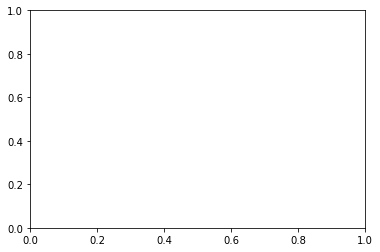

In [42]:
import imageio

num_images = 200
image_nums = [int(temp_image) for temp_image in np.linspace(1, num_time_steps - 2, num_images)]

for ii_index, ii_image in enumerate(image_nums):

    temp_particles = np.transpose(particle_history[str(ii_image)])
    temp_time = bin_size * np.linspace(0, np.shape(temp_particles)[0], np.shape(temp_particles)[0])
    plt.plot(temp_time, temp_particles, color = 'red')
    plt.xlim(0, bin_size * num_time_steps)
    plt.ylim(np.max(particles) - 2, np.min(particles) + 2)
    plt.title('Samples From Posterior of Latents')
    plt.savefig(f'latents_over_time/temp_fig{ii_index:.0f}.png')
    plt.close()

images = []
filenames = [f'latents_over_time/temp_fig{ii_image:.0f}.png' for ii_image in range(num_images)]

for filename in filenames:

    images.append(imageio.imread(filename))

print('Writing gif')
imageio.mimsave('particle_filter.gif', images)

## Plot the particle trajectories 

# np.shape(particles)
# plt.plot(bin_size * np.linspace(0, np.shape(particles)[1], np.shape(particles)[1]), np.transpose(particles), linewidth = 1, color = 'red', label = 'Posterior')
# plt.plot(time, state_trajectory, color = 'blue', label = 'Real')
# plt.title('Samples from Posterior Distribution of Latent Trajectory')
# plt.xlabel('Time (seconds)')
# plt.ylabel('State')
# plt.show()

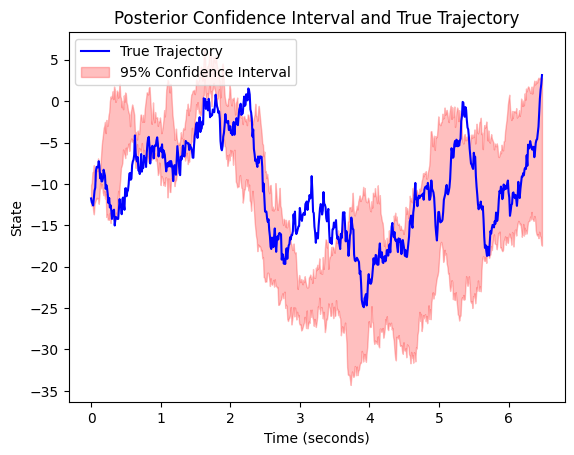

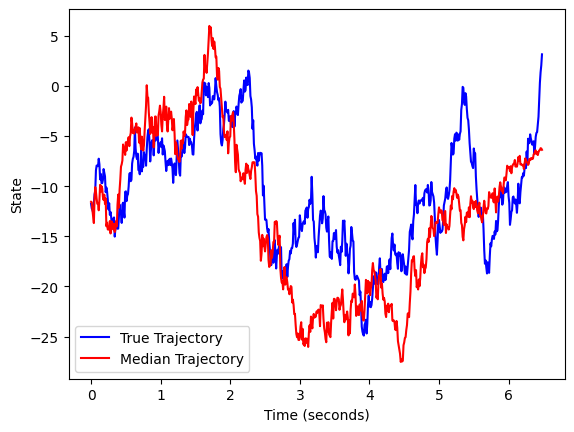

In [35]:
## Plot the quantiles of the distribution to show confidence interval 

quantiles = np.quantile(particles, [.975, .025], axis = 0)
np.shape(quantiles)
plt.plot(time, state_trajectory, color = 'blue', label = 'True Trajectory')
plt.title('Posterior Confidence Interval and True Trajectory')
plt.xlabel('Time (seconds)')
plt.ylabel('State')
plt.fill_between(time, quantiles[0, :], quantiles[1, :], color = 'red', alpha = .25, label = '95% Confidence Interval')
plt.legend()
plt.show()

## Just show the median prediction

median_trajectory = np.quantile(particles, .5, axis = 0)
plt.plot(time, state_trajectory, label = 'True Trajectory', color = 'blue')
plt.plot(time, median_trajectory, label = 'Median Trajectory', color = 'red')
plt.xlabel('Time (seconds)')
plt.ylabel('State')
plt.legend(loc = 'lower left')
plt.show()


Now, we compare how the median of the posterior distribution of the latent trajectory compares to randomly generated latent states of the same length. We use sum of squared errors as a measure of accuracy. 

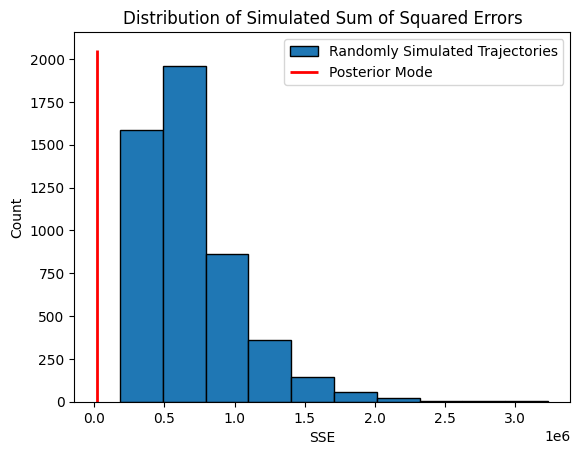

.05 quantile for the distribution of SSEs for randomly simulated trajectories is 304962.78
Posterior mode SSE is 18732.95
The posterior mode trajectory has statistically significant sum of squared errors


In [36]:
## Compare it to random trajectories simulated from the latent variable model 
## Plot the sequential importance resampling SSE compared to distribution of SSEs under chance 

num_rand_trajecs = 5000
rand_samples = np.zeros([1, num_time_steps, num_rand_trajecs])
valid_samples = 0

while valid_samples < num_rand_trajecs:

    current_val = intercept
    time = 1
    rand_trajectory = []

    while current_val < threshold:

        current_val += (beta + (np.sqrt(var) * np.random.normal()))
        rand_trajectory = np.append(rand_trajectory, current_val)
        time += 1

    if len(rand_trajectory) > num_time_steps:

        rand_trajectory = np.abs(rand_trajectory)
        rand_samples[0, :, valid_samples] = rand_trajectory[len(rand_trajectory) - num_time_steps :]
        valid_samples = valid_samples + 1

        # Calculate the sum of squared errors for each of the rand_trajectories

dist_sse = np.zeros([num_rand_trajecs])

for ii_rand_trajectory in range(num_rand_trajecs):

    temp_trajectory = rand_samples[0, :, ii_rand_trajectory]
    dist_sse[ii_rand_trajectory] = np.sum((temp_trajectory - state_trajectory) ** 2)

median_sse = np.sum((median_trajectory - state_trajectory) ** 2)
index = np.searchsorted(dist_sse, median_sse, side = 'right')
quantile = index / num_rand_trajecs

plt.hist(dist_sse, edgecolor = 'black', label = 'Randomly Simulated Trajectories')
plt.vlines(median_sse, ymin = plt.ylim()[0], ymax = plt.ylim()[1], color = 'red', linewidth = 2, label = 'Posterior Median')
plt.title('Distribution of Simulated Sum of Squared Errors')
plt.ylabel('Count')
plt.xlabel('SSE')
plt.legend()
plt.show()

print('.05 quantile for the distribution of SSEs for randomly simulated trajectories is {:.2f}'.format(np.quantile(dist_sse, .05)))
print('Posterior mode SSE is {:.2f}'.format(median_sse))

if median_sse <= np.quantile(dist_sse, .05):

    print('The posterior median trajectory has statistically significant sum of squared errors')
    
else:

    print('The posterior median trajectory does not have statistically signficant sum of squared errors')


Now, we generate observed data from the median of the posterior distribution of the latent trajectory. 

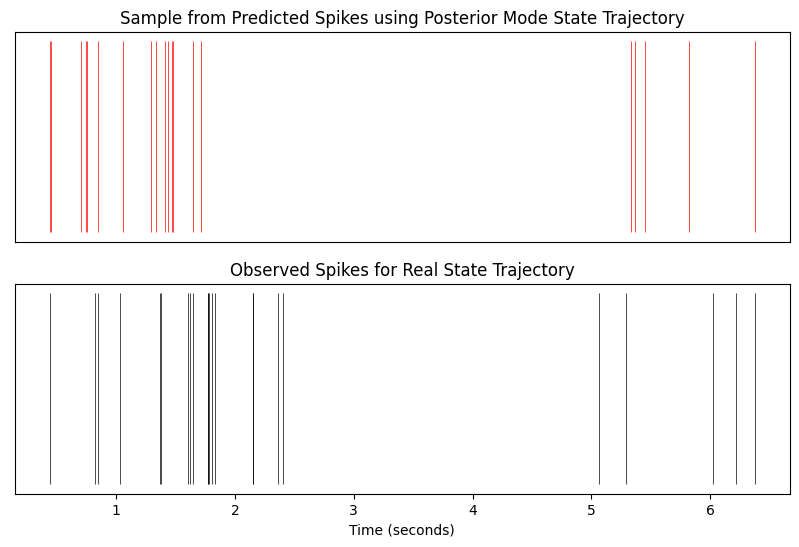

In [37]:
## Simulate the spike train from the median of the posterior using importance sampling, compare 

pred_rate_params, pred_spike_counts = state_to_lambda(median_trajectory, C, baseline)
pred_arrival_times = get_arrival_times(state_trajectory, pred_rate_params, pred_spike_counts, bin_size)

# Plot the spike train
fig_width = 10  # Width in inches
fig_height = 6  # Height in inches

# Create a figure with the specified width and height
plt.figure(figsize=(fig_width, fig_height))
plt.subplot(2, 1, 1)
plt.vlines(pred_arrival_times, ymin = 0, ymax = 1, linewidth = .5, color = 'red')
plt.xlabel('Time (seconds)')
plt.title('Sample from Predicted Spikes using Posterior Median State Trajectory')
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)

plt.subplot(2, 1, 2)
plt.vlines(arrival_times, ymin = 0, ymax = 1, linewidth = .5, color = 'black')
plt.xlabel('Time (seconds)')
plt.title('Observed Spikes for Real State Trajectory')
plt.gca().yaxis.set_visible(False)

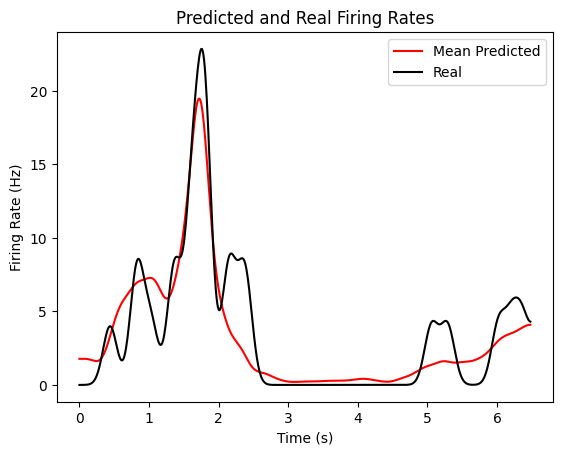

In [48]:
num_samples = 50000
pred_spike_counts_dist = np.zeros([1, len(median_trajectory), num_samples])

for ii_sample in range(num_samples):

    temp, pred_spike_counts_dist[:, :, ii_sample] = state_to_lambda(median_trajectory, C, baseline)

pred_firing_rates_dist = pred_spike_counts_dist / bin_size
mean_pred_firing_rates = np.squeeze(np.mean(pred_firing_rates_dist, axis = 2))
real_firing_rates = spike_counts / bin_size
smoothed_mean_pred_rates = gaussian_filter1d(mean_pred_firing_rates, sigma = 10)
smoothed_real_rates = gaussian_filter1d(real_firing_rates, sigma = 10)
time = np.array(range(len(state_trajectory))) * bin_size

plt.plot(time, smoothed_mean_pred_rates, color = 'red', label = 'Mean Predicted')
plt.plot(time, smoothed_real_rates, color = 'black', label = 'Real')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Predicted and Real Firing Rates')
plt.show()

We can see that SIR estimates the latent trajectory well enough to recreate the observed data fairly well on average. 